In [391]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [392]:
# Global parameters
N = 128  # no. data points
N_iters = 1000  # max no. iterations before stopping
noise_std = 0.1
beta_tol = 1e-8  # beta tolerance for stopping iteration when |beta_new - beta_old| <= beta_tol
rng_seed = 2023

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10 * x + 2 * x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # ??

beta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)  # own OLS inversion

# Hessian matrices 
H_ols = 2 / N * X.T @ X
eig_ols, iter = np.linalg.eig(H_ols)
print(f"OLS: 1/lambda_max={1 / max(eig_ols):.3f}")

OLS: 1/lambda_max=0.390


# Plain gradient descent (GD) convergence as function of fixed learning rate

### OLS:

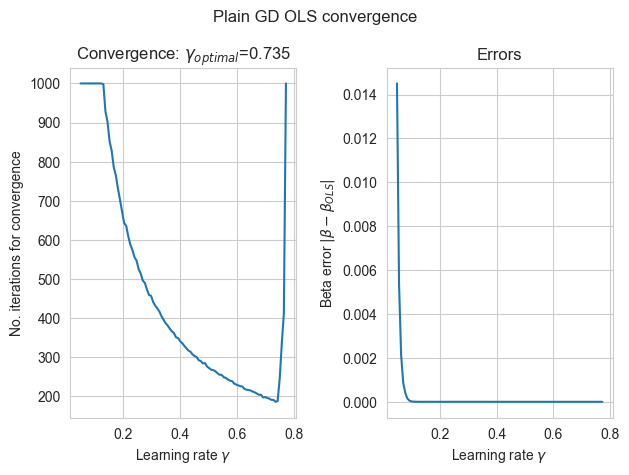

In [393]:
# Parameters
learn_rates = np.linspace(0.05, 2 / np.max(eig_ols), 100, endpoint=False)

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Update beta
        grad = 2 / N * X.T @ (X @ beta - y)
        beta -= learn_rate * grad

        iter += 1
    no_iters[i] = iter

    error = np.max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [394]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.63898721 -7.93024817]
Best beta=[ 4.63898721 -7.93024817]
Fastest convergence=186.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.63843602 -7.92924881], beta=[ 4.56952856 -7.80431828], max error=0.1369400993805856
lmbda=0.01, beta_ridge=[ 4.63348146 -7.9202657 ], beta=[ 4.03000387 -6.82660793], max error=1.097498430834749
lmbda=0.1, beta_ridge=[ 4.58453656 -7.83152704], beta=[ 1.90644197 -2.99719632], max error=4.834331326375045
lmbda=1, beta_ridge=[ 4.14853073 -7.04132091], beta=[ 0.38194457 -0.40986898], max error=6.631451859458876
lmbda=10, beta_ridge=[ 2.17463702 -3.47741008], beta=[ 0.05203054 -0.03686428], max error=3.4405142051370934


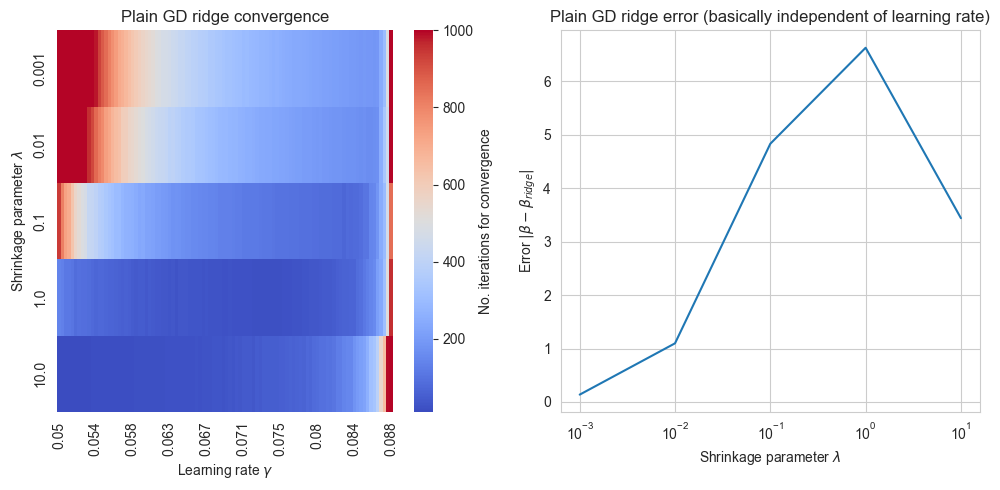

In [403]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Update beta
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            beta -= learn_rate * grad

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = np.max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        # norm="log"
)
plt.xticks(rotation=90)  # sideways xticks
ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [396]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

Min no. iterations=10.0
Fastest convergence combination (gamma, lambda)=(0.050, 10.000) with error=3.441


This does not look right to me, 9 iterations is way to low, as we see with the error increasing very much... I'm not sure where my logic fault is atm.

# Gradient descent with momentum/memory (GDM) as function of fixed learning rate

### OLS:

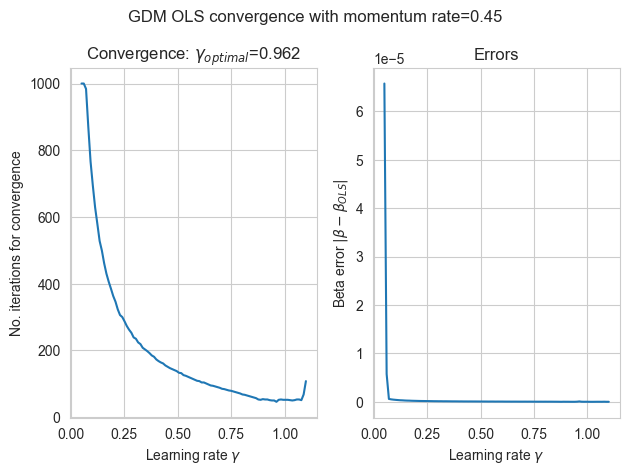

In [397]:
# Parameters
learn_rates = np.linspace(0.05, 1.1, 100)
momentum_rate = 0.45  # memory rate

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    change = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Calculate new change
        grad = 2 / N * X.T @ (X @ beta - y)
        new_change = learn_rate * grad + momentum_rate * change

        # Update values
        beta -= new_change
        change = new_change.copy()
        iter += 1
    no_iters[i] = iter

    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"GDM OLS convergence with momentum rate={momentum_rate}")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [398]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.63898721 -7.93024817]
Best beta=[ 4.63898721 -7.93024817]
Fastest convergence=46.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.63843602 -7.92924881], beta=[ 4.56952856 -7.80431824], max error=0.12498309151954512
lmbda=0.01, beta_ridge=[ 4.63348146 -7.9202657 ], beta=[ 4.03000387 -6.82660795], max error=1.0936661778750931
lmbda=0.1, beta_ridge=[ 4.58453656 -7.83152704], beta=[ 1.90644198 -2.99719632], max error=4.834331047497437
lmbda=1, beta_ridge=[ 4.14853073 -7.04132091], beta=[ 0.38194459 -0.40986902], max error=6.63145191524087
lmbda=10, beta_ridge=[ 2.17463702 -3.47741008], beta=[ 0.05197307 -0.03689588], max error=3.440514203778


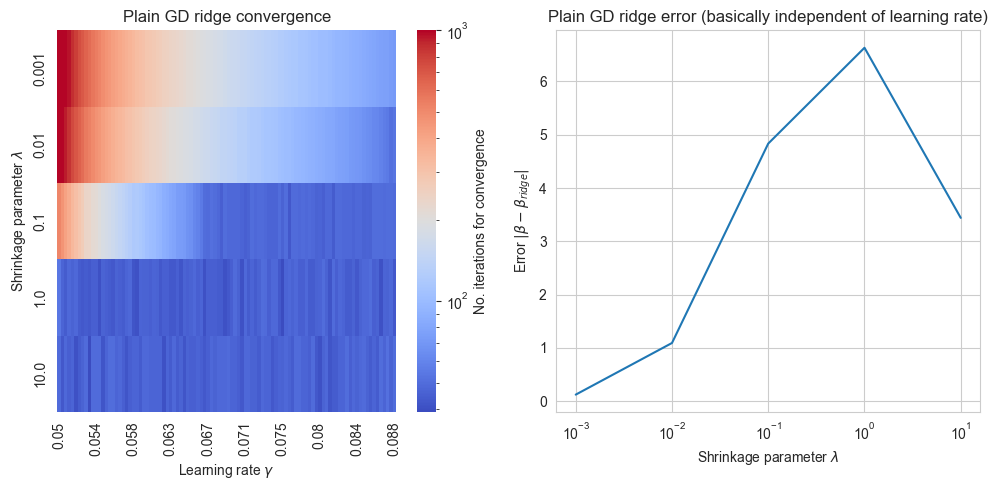

In [399]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        change = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Calculate new change
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            new_change = learn_rate * grad + momentum_rate * change

            # Update values
            beta -= new_change
            change = new_change.copy()
            iter += 1

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

        no_iters[i, j] = iter
        errors[i, j] = max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        norm="log",  # colorbar to log scale,
        cbar_kws={"label": "No. iterations for convergence"}  # colorbar label
)
plt.xticks(rotation=90)  # sideways xticks
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [400]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

Min no. iterations=39.0
Fastest convergence combination (gamma, lambda)=(0.053, 10.000) with error=3.441


Again I'm not sure this is correct.

# Stochastic gradient descent (SDG) as function of batch size $M$ and number of epochs $N_\text{epochs}$, with replacement

### OLS:

Text(0.5, 23.52222222222222, 'Size of each minibatch $M$')

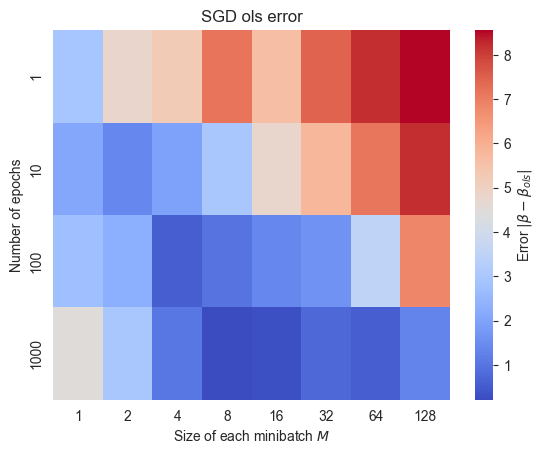

In [401]:
# SDG parameters
M_vals = np.asarray([1, 2, 4, 8, 16, 32, 64, 128])  # size of each minibatch
N_epoch_vals = [1, 10, 100, 1000]  # number of iterations over all the minibatches 

m_vals = (N / M_vals).astype(int)  # number of minibatches

def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    t0 = 5
    t1 = 50
    return t0 / (t + t1)


errors = np.empty((M_vals.size, len(N_epoch_vals)))
for j, N_epoch in enumerate(N_epoch_vals):  # iterate through different epochs values
    # then iterate through different values of total number of batches m (and corresponding M)
    for i, m in enumerate(m_vals):  
        M = M_vals[j]
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]
        
        for epoch in range(N_epoch):  # then iterate through all different epoch values
            for k in range(m):  # now do the GD calculation for each of the minibatches
                # Pick a minibatch at random
                random_index = M * rng.integers(m)  
                xk = X[random_index:random_index + M]
                yk = y[random_index:random_index + M]
                
                # Gradient descent on the random batch
                gradients = 2 / M * xk.T @ ((xk @ beta) - yk)
                learn_rate = learning_schedule(epoch * m + k)
                beta -= learn_rate * gradients
        errors[i, j] = np.max(abs(beta - beta_ols))
        
# Error heatmap
plt.figure()
plt.title("SGD ols error")
ax = sb.heatmap(
        errors.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=M_vals,
        yticklabels=N_epoch_vals,
)
ax.collections[0].colorbar.set_label(r"Error $|\beta - \beta_{ols}|$")
plt.ylabel("Number of epochs")
plt.xlabel("Size of each minibatch $M$")